<a href="https://colab.research.google.com/github/lucacerab/DSEthesis-transformers/blob/main/UKPall_binaryAM_testonessays.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finetuning BERT for argumentative sentence detection

dataset: https://tudatalib.ulb.tu-darmstadt.de/handle/tudatalib/2345

labels: 0 = no argument; 1 = argument for; 2 = argument against

## Load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
import pandas as pd
import numpy as np
!pip install transformers
from transformers import BertTokenizer
from transformers import TFAutoModel
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Model
from keras.utils.vis_utils import plot_model

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/data/trainwithtopic.csv')
val_df = pd.read_csv('/content/drive/MyDrive/data/valwithtopic.csv')
test_df = pd.read_csv('/content/drive/MyDrive/data/testwithtopic.csv')

In [ ]:
#adapt labels to binary classification merging argument for and argument against
train_df.loc[train_df['label'] == 2, 'label'] = 1
val_df.loc[val_df['label'] == 2, 'label'] = 1
test_df.loc[test_df['label'] == 2, 'label'] = 1

In [ ]:
#combine train, dev and test splits
ukp_frames = [train_df, val_df, test_df]
ukp = pd.concat(ukp_frames)

In [ ]:
#shuffle
ukp = ukp.sample(frac=1, random_state=123).reset_index(drop=True)
print(ukp.shape)
print()
ukp.head()

(25492, 3)



,topic,sentence,label
0,death penalty,There is no fear of death for him .,0
1,school uniforms,This is especially the case when the student s...,0
2,death penalty,And most of the executions that are carried ou...,1
3,marijuana legalization,They must state the method of administration a...,0
4,abortion,"Source : Maggie Haberman , "" Pressed on Aborti...",0


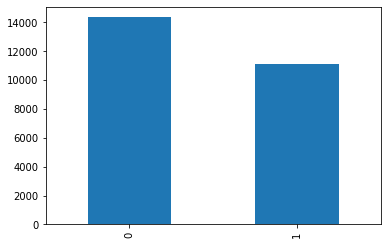

In [ ]:
ukp.label.value_counts().plot(kind='bar')

In [ ]:
print(ukp.topic.nunique(), 'topics:', ukp.topic.unique())

8 topics: ['death penalty' 'school uniforms' 'marijuana legalization' 'abortion'
 'nuclear energy' 'gun control' 'cloning' 'minimum wage']


In [ ]:
ukp.head()

,topic,sentence,label
0,death penalty,There is no fear of death for him .,0
1,school uniforms,This is especially the case when the student s...,0
2,death penalty,And most of the executions that are carried ou...,1
3,marijuana legalization,They must state the method of administration a...,0
4,abortion,"Source : Maggie Haberman , "" Pressed on Aborti...",0


## Preparing data for BERT

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
#function to encode bert input

#length of sentences
max_len = 128
def bert_encode(df, max_len):
  num_samples = len(df)

  X_ids = np.zeros((num_samples, max_len))
  X_mask = np.zeros((num_samples, max_len))
  X_type_ids = np.zeros((num_samples, max_len))
  

  for i, row in df.iterrows():
      encoded = tokenizer.encode_plus(row['topic'], row['sentence'], max_length=max_len,
                                      truncation=True, padding='max_length', add_special_tokens=True)    
      X_ids[i, :] = encoded['input_ids']
      X_mask[i, :] = encoded['attention_mask'] 
      X_type_ids[i, :] = encoded['token_type_ids'] 
  return X_ids, X_mask, X_type_ids

In [ ]:
train_input_ids, train_attention_masks, train_token_type_ids = bert_encode(ukp, max_len)

In [ ]:
train_labels = ukp.label.values

## Training the model

In [ ]:
bert = TFAutoModel.from_pretrained('bert-base-cased')
bert.summary()

Downloading:   0%|          | 0.00/527M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "tf_bert_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  108310272 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#define hyperparams
drop = 0.6

optimizer = Adam(learning_rate=2e-5)
loss = 'binary_crossentropy'

#fine tune bert
trainable = True

In [ ]:
def create_model(bert):
  input_ids = Input(shape=(max_len,), name="input_word_ids", dtype='int32')
  attention_masks = Input(shape=(max_len,), name="input_mask", dtype='int32')
  type_ids = Input(shape=(max_len,), name="segment_ids", dtype='int32')

  embeddings = bert.bert([input_ids, attention_masks, type_ids])[1]

  x = Dense(512, activation='relu')(embeddings)
  dropout = Dropout(drop, name='dropout')(x)
  output = Dense(1, activation='sigmoid', name='outputs')(dropout)
  
  model = Model(inputs = [input_ids, attention_masks, type_ids], outputs = output)
  model.layers[3].trainable = trainable
  model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

  return model

In [ ]:
model = create_model(bert)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 108310272   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

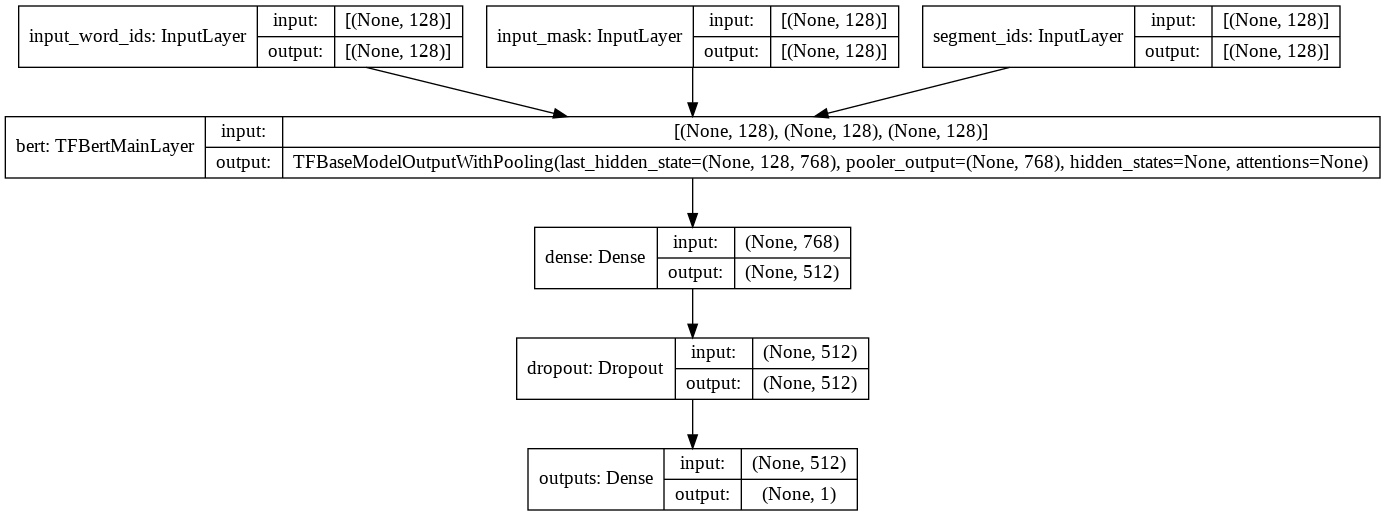

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
epochs = 3
batch_size = 16

history = model.fit([train_input_ids, train_attention_masks, train_token_type_ids], train_labels,
                    #validation_data=([val_input_ids, val_attention_masks, val_token_type_ids], val_labels),
                    epochs=epochs, batch_size=batch_size)

Epoch 1/3
1594/1594 [==============================] - 889s 549ms/step - loss: 0.4564 - accuracy: 0.7844
Epoch 2/3
1594/1594 [==============================] - 879s 551ms/step - loss: 0.3047 - accuracy: 0.8692
Epoch 3/3
1594/1594 [==============================] - 879s 552ms/step - loss: 0.1776 - accuracy: 0.9303


In [ ]:
model.save('UKPentire_binary.h5')
!cp /content/UKPentire_binary.h5 /content/drive/MyDrive/

## Load the model from drive and test it on custom sentences

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%%capture
!pip install transformers
from transformers import TFAutoModel
from transformers import BertTokenizer
from tensorflow import keras
import pandas as pd
import numpy as np

In [ ]:
bert = TFAutoModel.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/527M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/tesi/AM/binary/UKP_binary/UKP_binary_final/UKP_binary_finetuned/UKPentire_binary.h5')

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [ ]:
max_len = 128
def bert_encode(df, max_len):
  num_samples = len(df)

  X_ids = np.zeros((num_samples, max_len))
  X_mask = np.zeros((num_samples, max_len))
  X_type_ids = np.zeros((num_samples, max_len))
  

  for i, row in df.iterrows():
      encoded = tokenizer.encode_plus(row['topic'], row['sentence'], max_length=max_len,
                                      truncation=True, padding='max_length', add_special_tokens=True)    
      X_ids[i, :] = encoded['input_ids']
      X_mask[i, :] = encoded['attention_mask'] 
      X_type_ids[i, :] = encoded['token_type_ids'] 
  return X_ids, X_mask, X_type_ids

In [ ]:
#create dataset with custom sentences
topic = ['zoo']*5 + ['autonomous cars']
sentences = ['A zoo is a facility in which all animals are housed within enclosures, displayed to the public, and in which they may also breed.', 'Zoos produce helpful scientific research.',
         'Zoos save species from extinction and other dangers.', 'Zoo confinement is psychologically damaging to animals.', "Zoos are detrimental to animals' physical health.", 
         "Zoos are detrimental to animals' physical health."]
labels = ['NoArgument', 'Argument', 'Argument', 'Argument', 'Argument', 'NoArgument']

d = {'topic': topic, 'sentence': sentences, 'label': labels} 
df = pd.DataFrame(d)

In [ ]:
df

,topic,sentence,label
0,zoo,A zoo is a facility in which all animals are h...,NoArgument
1,zoo,Zoos produce helpful scientific research.,Argument
2,zoo,Zoos save species from extinction and other da...,Argument
3,zoo,Zoo confinement is psychologically damaging to...,Argument
4,zoo,Zoos are detrimental to animals' physical health.,Argument
5,autonomous cars,Zoos are detrimental to animals' physical health.,NoArgument


In [ ]:
#encode the input
X_ids, X_mask, X_type_ids = bert_encode(df, max_len)

In [ ]:
results = model.predict([X_ids, X_mask, X_type_ids])

In [ ]:
preds = np.round(results).astype(int)

In [ ]:
df['preds'] = preds

In [ ]:
df

,topic,sentence,label,preds
0,zoo,A zoo is a facility in which all animals are h...,NoArgument,0
1,zoo,Zoos produce helpful scientific research.,Argument,1
2,zoo,Zoos save species from extinction and other da...,Argument,1
3,zoo,Zoo confinement is psychologically damaging to...,Argument,1
4,zoo,Zoos are detrimental to animals' physical health.,Argument,1
5,autonomous cars,Zoos are detrimental to animals' physical health.,NoArgument,0
